# SHAP in any model
Sara Echeverría 21371
- Repository: https://github.com/bl33h/shap

Image 1: {'tabby, tabby cat': 0.7466779351234436, 'tiger cat': 0.23310865461826324, 'Egyptian cat': 0.014172052033245564, 'lynx, catamount': 0.00046098895836621523, 'marmoset': 0.00019128464919049293}
Image 2: {'golden retriever': 0.9656769633293152, 'Labrador retriever': 0.01827777549624443, 'otterhound, otter hound': 0.0013211818877607584, 'Tibetan mastiff': 0.0010660573607310653, 'clumber, clumber spaniel': 0.0009317424846813083}
Image 3: {'African chameleon, Chamaeleo chamaeleon': 0.9505360722541809, 'American chameleon, anole, Anolis carolinensis': 0.007016523741185665, 'green lizard, Lacerta viridis': 0.0056025441735982895, 'common iguana, iguana, Iguana iguana': 0.0019673919305205345, 'agama': 0.0019193930784240365}


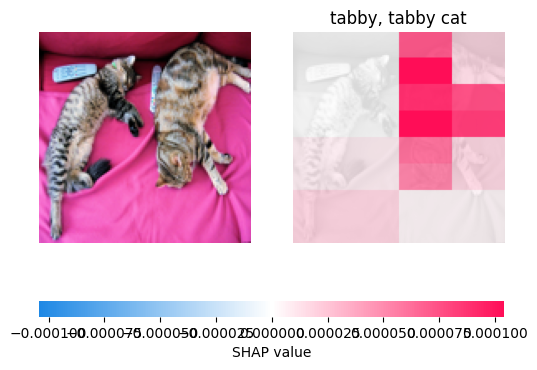

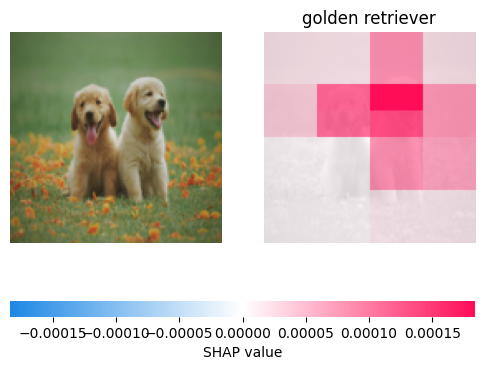

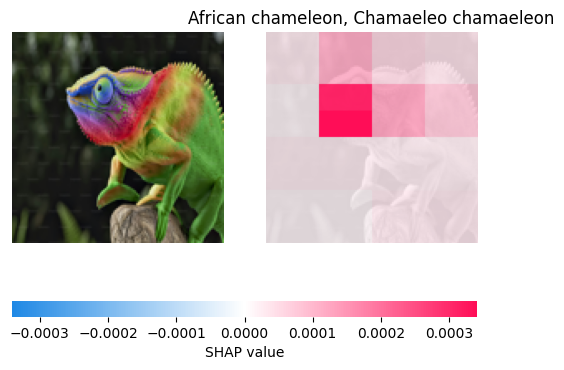

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import AutoImageProcessor, MobileNetV2ForImageClassification
from datasets import load_dataset
import torch
import shap
import numpy as np
from PIL import Image

processor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
model = MobileNetV2ForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

dataset = load_dataset("huggingface/cats-image")
images = [
    dataset["test"]["image"][0],
    Image.open("img/dog.jpg"),
    Image.open("img/ch.jpg")
]

inputs = processor(images=images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)

preds = []
for i, p in enumerate(probs):
    topk = torch.topk(p, 5)
    predDict = {model.config.id2label[idx.item()]: float(score) for idx, score in zip(topk.indices, topk.values)}
    preds.append(predDict)
    print(f"Image {i+1}: {predDict}")

def predictFn(imgs):
    inputs = processor(images=list(imgs), return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.nn.functional.softmax(logits, dim=-1).numpy()

for i, img in enumerate(images):
    imgResized = img.resize((128, 128))
    imgNp = np.array(imgResized).astype(np.uint8)
    masker = shap.maskers.Image(0, imgNp.shape)
    explainer = shap.explainers.Partition(predictFn, masker)
    topIdx = torch.argmax(probs[i]).item()
    shapValues = explainer(np.array([imgNp]), max_evals=50, batch_size=10, outputs=[topIdx])
    shap.image_plot(shapValues, labels=[model.config.id2label[topIdx]])

## Reflexión
Los resultados tienen sentido, ya que SHAP resalta principalmente las zonas del animal que influyen en la predicción, mientras que el fondo casi no aporta. Esto indica que el modelo se enfoca en las características relevantes y no en detalles irrelevantes.